# Hillfort detection with LiDAR data
## Data management

## Table of contents

[Code](#code)

1. [**Defined functions**](#defined-functions)
2. [**Data gathering**](#data-gathering)
3. [**Data preprocessing**](#data-preprocessing)
4. [**Data augmentation**](#data-augmentation)

[End](#end)

## Code

### Defined functions

In [ ]:
# Module installs
!pip install zipfile pandas numpy shapely matplotlib laspy tqdm geopandas

In [ ]:
# If you have GPU
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Otherwise
!pip3 install torch torchvision torchaudio

In [1]:
# Imports
import os
import random
import logging
import zipfile
import pandas as pd
import numpy as np
import shapely # For optimized shape functions
import matplotlib.pyplot as plt
import laspy # Reading LAS file format
from tqdm import tqdm # Loading bars
import geopandas as gpd # Reading .shp files
import lib.download_maps # Custom downloading script

In [2]:
# Configurations
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler()  # Direct logs to the notebook's output
    ]
)

GLOBAL_MIN_X, GLOBAL_MAX_X = 6374000, 6641000
GLOBAL_MIN_Y, GLOBAL_MAX_Y = 364000, 742000
GLOBAL_MIN_Z, GLOBAL_MAX_Z = -125, 320 # Munamägi

In [174]:
def normalize_lidar_and_polygons(hillfort_polygons_df, input_laz_dir, output_laz_dir, output_csv_filepath):
    """
    Normalizes LiDAR data and corresponding polygons based on the unnormalized bounding box of each LAS file.

    Parameters:
        hillfort_polygons_df (pd.DataFrame): DataFrame with 'laz_file' and 'polygons' columns.
        input_laz_dir (str): Directory containing input LAS files.
        output_laz_dir (str): Directory to save normalized LAS files.
        output_csv_file (str): CSV file containing normalized output polygons.
    """
    if not os.path.exists(output_laz_dir):
        os.makedirs(output_laz_dir)

    normalized_polygons = []

    for _, row in tqdm(hillfort_polygons_df.iterrows(), total=hillfort_polygons_df.shape[0]):
        laz_file = row['laz_file']
        polygons = row['polygons']

        input_path = os.path.join(input_laz_dir, laz_file)
        output_path = os.path.join(output_laz_dir, laz_file)

        # Read LAS file
        las = laspy.read(input_path)

        # Normalize LiDAR data
        # Normalize x, y, z
        new_x = (las.x - GLOBAL_MIN_Y) / (GLOBAL_MAX_Y - GLOBAL_MIN_Y)
        new_y = (las.y - GLOBAL_MIN_X) / (GLOBAL_MAX_X - GLOBAL_MIN_X)
        new_z = (las.z - GLOBAL_MIN_Z) / (GLOBAL_MAX_Z - GLOBAL_MIN_Z)

        # Update the header for new scale and offset
        las.header.offsets = [0.0, 0.0, 0.0]  # Reset offsets to 0.0
        las.header.scales = [1e-9, 1e-9, 1e-9]  # Small scale to preserve precision

        # Assign normalized coordinates back
        las.x = new_x
        las.y = new_y
        las.z = new_z

        # Save normalized LAS file
        las.write(output_path)

        # Normalize polygons using the same bounding box
        normalized = []
        for polygon in polygons:
            scaled = shapely.affinity.scale(
                polygon,
                xfact=1 / (GLOBAL_MAX_Y - GLOBAL_MIN_Y),
                yfact=1 / (GLOBAL_MAX_X - GLOBAL_MIN_X),
                origin=(GLOBAL_MIN_Y, GLOBAL_MIN_X)
            )
            normed = shapely.affinity.translate(scaled, xoff=-GLOBAL_MIN_Y, yoff=-GLOBAL_MIN_X)
            normalized.append(normed)

        # Append normalized polygons with laz_file reference
        normalized_polygons.append({'laz_file': laz_file, 'polygons': normalized})

    # Convert normalized polygons back to a DataFrame
    normalized_polygons_df = pd.DataFrame(normalized_polygons)
    
    # Convert the list of polygons to a list of WKT strings
    normalized_polygons_df['polygons_wkt'] = normalized_polygons_df['polygons'].apply(lambda polygons: [p.wkt for p in polygons])

    # Save to CSV
    normalized_polygons_df[['laz_file', 'polygons_wkt']].to_csv(output_csv_filepath, index=False)

    print(f"Normalized LAS files saved to: {output_laz_dir}")
    print(f"Normalized polygons saved to: {output_csv_filepath}")

In [220]:
def downsample_lidar(input_laz_dir, grid_size=1e-4, output_laz_dir='../data/downsampled_class_lazFiles'):
    """
    Downsamples a LAS file using grid method and saves them to specified path.

    Parameters:
        input_laz_dir (str): Directory containing input LAS files.
        grid_size (float): Size of grid cells for grid-based downsampling.
        output_laz_dir (str): Directory to save normalized LAS files.
    """
    if not os.path.exists(output_laz_dir):
        os.makedirs(output_laz_dir)

    laz_files = os.listdir(input_laz_dir)

    for laz_file in tqdm(laz_files, total=len(laz_files)):

        input_path = os.path.join(input_laz_dir, laz_file)
        output_path = os.path.join(output_laz_dir, laz_file)

        # Read LAS file
        las = laspy.read(input_path)

        # Calculate grid indices for each point
        grid_x = np.floor(las.x / grid_size)
        grid_y = np.floor(las.y / grid_size)

        # Combine grid indices into tuples
        grid_indices = list(zip(grid_x, grid_y))

        # Group points by grid cell
        grid_point_map = {}
        for idx, grid in enumerate(grid_indices):
            if grid not in grid_point_map:
                grid_point_map[grid] = []
            grid_point_map[grid].append(idx)

        # Downsample by keeping a representative sample of points in each grid cell
        sampled_indices = []
        for points_in_cell in grid_point_map.values():
            # Option 1: Keep a fixed percentage of points per cell
            sampled_indices.extend(random.sample(points_in_cell, max(1, len(points_in_cell) // 50)))

            # Option 2: Keep a fixed number of points per cell (e.g., up to 5)
            # sampled_indices.extend(points_in_cell[:5])  # Adjust this value as needed

        # Create the downsampled LAS file
        downsampled_las = laspy.create(file_version=las.header.version, point_format=las.header.point_format)

        # Copy header information (scale and offset) explicitly
        downsampled_las.header.scales = las.header.scales
        downsampled_las.header.offsets = las.header.offsets

        # Copy downsampled point data
        for dim in las.point_format.dimension_names:
            setattr(downsampled_las, dim, getattr(las, dim)[sampled_indices])

        # Save the downsampled LAS file
        downsampled_las.write(output_path, do_compress=True)

In [5]:
def gather_hillforts(laz_files_path='../data/lazFiles/', map_numbers_file='../data/linnamagede_ruudunumbrid.csv', hillfort_polygons_file='../data/inspire/PS_ProtectedSite_malestisedPolygon.shp'):
    """
    Processes hillfort polygon data and associates it with LiDAR laz files.

    This function reads hillfort polygon data and matches each polygon to the appropriate
    LiDAR laz files based on square numbers. The resulting dataset links each laz file
    to the polygons it intersects.

    Parameters:
        laz_files (list, optional): Path to laz files. If None, reads files from '../data/lazFiles/'.
        map_numbers_file (str, optional): Path to the CSV file containing square numbers and hillfort IDs.
        hillfort_polygons_file (str, optional): Path to the shapefile containing hillfort polygon geometries.

    Returns:
        pd.DataFrame: Optimized DataFrame with columns:
            'laz_file': Name of the LiDAR laz file.
            'polygons': List of shapely.Polygon objects associated with each laz file.
    """
    # Load laz files
    laz_files = os.listdir('../data/lazFiles/')

    # Read hillfort data file
    gdf_inspire = gpd.read_file(hillfort_polygons_file)
    # Read lidar map numbers file
    map_numbers = pd.read_csv(map_numbers_file, sep=',')
    # Remove rows if no map number or INSPIRE id
    map_numbers = map_numbers.dropna(subset=['Ruudunumber', 'INSPIRE id'], how='any')

    # Find hillfort polygons
    hillfort_polygons = []
    for _, row in map_numbers.iterrows():
        polygon_series = gdf_inspire[gdf_inspire['inspireid_'] == row['INSPIRE id']]['geometry']
        if polygon_series.empty:
            logging.info(f"No polygon found for hillfort: {row['Linnamägi']}")
            continue
        # Add polygons as individual geometries
        hillfort_polygons.append([row['Ruudunumber'], polygon_series.values.tolist()])
    
    # Convert hillfort polygons to DataFrame
    hillfort_polygons_df = pd.DataFrame(hillfort_polygons, columns=['square_nr', 'polygon'])

    # Match laz files based on square_nr
    def match_laz_files(square_nr):
        square_nums = [num.strip() for num in str(square_nr).split(",")]
        matching_files = [file for file in laz_files if any(num in file for num in square_nums)]
        return matching_files

    # Add laz_files column to polygons DataFrame
    hillfort_polygons_df['laz_files'] = hillfort_polygons_df['square_nr'].apply(match_laz_files)

    # Normalize the DataFrame: explode laz_files
    normalized_df = hillfort_polygons_df.explode('laz_files')[['laz_files', 'polygon']]

    # Group by laz_file and aggregate polygons into a flat list
    def flatten_polygon_lists(polygons):
        # Flatten nested lists of polygons
        return [geom for sublist in polygons for geom in sublist]

    # Optimize: group by laz_file and aggregate polygons into a list
    optimized_df = normalized_df.groupby('laz_files', as_index=False).agg({'polygon': flatten_polygon_lists})

    # Rename columns for clarity
    optimized_df.rename(columns={'laz_files': 'laz_file', 'polygon': 'polygons'}, inplace=True)

    return optimized_df

In [6]:
# Modify LAS points' classification inside the polygon
def classify_points_in_multiple_areas(las, polygons, new_classification, output_path):
    """
    Updates the classification of LAS file points within multiple polygons.

    Parameters:
        las (str): Input LAS file.
        polygons (list): List of shapely.Polygon objects to classify points inside.
        new_classification (int): New classification value for points within the polygons.
        output_path (str): Path to save the modified LAS file.
    """

    # Extract LAS point X, Y coordinates
    points = np.column_stack((las.x, las.y))

    # Convert points to a Shapely GeometryArray (vectorized)
    points_geom = shapely.points(points)

    # Create a cumulative mask for all polygons
    mask = np.zeros(len(points), dtype=bool)

    for polygon in polygons:
        # Pre-filter points using the polygon's bounding box
        bbox_mask = shapely.contains(shapely.box(*polygon.bounds), points_geom)

        # Apply fine-grained point-in-polygon test to remaining points
        final_mask = shapely.contains(polygon, points_geom[bbox_mask])

        # Combine masks
        mask[bbox_mask] |= final_mask

    # Apply the new classification to points within any polygon
    las.classification[mask] = new_classification

    # Write modified points to a new LAS file
    las.write(output_path)

In [7]:
def mark_polygons_in_las(input_laz_dir, output_laz_dir, polygons, new_classification):
    """Labels all the points in the given polygons with the new classification in each las file.

    Parameters:
        input_laz_dir (string): Path to the laz files directory
        output_laz_dir (string): Path to the modified laz files directory
        polygons (Polygon): Hillfort area polygons
        new_classification (int): The new number to label the points with
    """
    if not os.path.exists(output_laz_dir):
        os.makedirs(output_laz_dir)

    for _, row in tqdm(polygons.iterrows(), total=polygons.shape[0]):
        laz_file = row['laz_file']
        polygons = row['polygons']

        # Paths
        input_path = os.path.join(input_laz_dir, laz_file)
        output_path = os.path.join(output_laz_dir, laz_file)

        # Read the LAS file
        las = laspy.read(input_path)

        # Classify points within polygons
        classify_points_in_multiple_areas(las, polygons, new_classification, output_path)

        del las
    print(f"Processed files and saved to {output_laz_dir}")

In [8]:
# Rasterize a shapely polygon for overlay
def rasterize_polygon(polygon, x_min, x_max, y_min, y_max, resolution):
    """
    Converts a polygon into a binary mask over a 2D grid.

    Parameters:
        polygon (shapely.Polygon): Polygon to rasterize.
        x_min, x_max, y_min, y_max (float): Bounding box of the grid.
        resolution (int): Resolution of the grid (number of rows/columns).

    Returns:
        np.ndarray: 2D binary mask (1 inside the polygon, 0 outside).
    """
    # Initialize an empty grid
    grid = np.zeros((resolution, resolution), dtype=np.uint8)
    
    # Create evenly spaced coordinates within the bounding box
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    
    # Iterate through each grid cell and check if it is within the polygon
    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            if polygon.contains(shapely.Point(x, y)):  # Check if the grid point is inside the polygon
                grid[i, j] = 1  # Mark the grid cell as inside the polygon
    return grid

In [9]:
# Function to blend mask into an image with transparency
def apply_transparency(image, mask, mask_color, alpha):
    """
    Applies a semi-transparent mask overlay to an image.

    Parameters:
        image (np.ndarray): Original RGB image (H x W x 3).
        mask (np.ndarray): Binary mask (H x W) where 1 indicates the mask region.
        mask_color (list): RGB color for the mask (e.g., [255, 0, 0] for red).
        alpha (float): Transparency level (0 to 1, where 1 is fully opaque).

    Returns:
        np.ndarray: RGB image with the mask applied.
    """
    # Create a copy of the original image to avoid overwriting
    blended_image = image.copy()
    
    # Get indices where the mask is active
    mask_indices = mask == 1  # Binary mask where 1 indicates the mask area
    
    # Blend mask color with the original image in the masked region
    for channel in range(3):  # Loop over RGB channels
        blended_image[..., channel][mask_indices] = (
            (1 - alpha) * blended_image[..., channel][mask_indices] + alpha * mask_color[channel]
        )
    
    return blended_image

In [10]:
def generate_color_image(laz_files, resolution=512, additional_features=[]):
    """
    Generates a color image from multiple LAZ files.

    Parameters:
        laz_files (list): List of LAZ objects containing point cloud data.
        resolution (int): Resolution for the output grid.
        additional_features (list): List of additional features to include (e.g., 'z', 'classification').

    Returns:
        tuple: (color_image, additional_feature_maps)
            - color_image: 3D numpy array (H x W x 3) for RGB.
            - additional_feature_maps: Dictionary of feature maps for additional features.
    """
    # Initialize color image
    color_image = np.zeros((resolution, resolution, 3), dtype=np.uint8)

    # Additional feature maps
    feature_maps = {feature: np.zeros((resolution, resolution)) for feature in additional_features}

    for las in laz_files:
        # Extract X, Y, RGB
        x, y = las.x, las.y
        red, green, blue = las.red, las.green, las.blue

        # Extract additional features
        features = {feature: getattr(las, feature) for feature in additional_features}

        # Normalize X, Y to fit into a 2D grid
        x_min, x_max = np.min(las.header.x_min), np.max(las.header.x_max)
        y_min, y_max = np.min(las.header.y_min), np.max(las.header.y_max)

        x_norm = ((x - x_min) / (x_max - x_min)) * (resolution - 1)
        y_norm = ((y - y_min) / (y_max - y_min)) * (resolution - 1)

        # Convert to integers for indexing
        x_indices = np.clip(x_norm.astype(np.int32), 0, resolution - 1)
        y_indices = np.clip(y_norm.astype(np.int32), 0, resolution - 1)

        # Flatten indices
        flat_indices = y_indices * resolution + x_indices
        unique_indices, inverse_indices = np.unique(flat_indices, return_inverse=True)

        # Aggregate RGB values
        red_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
        green_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
        blue_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)

        np.add.at(red_aggregated, inverse_indices, red / 65535 * 255)
        np.add.at(green_aggregated, inverse_indices, green / 65535 * 255)
        np.add.at(blue_aggregated, inverse_indices, blue / 65535 * 255)

        # Assign to color image
        color_image.flat[unique_indices * 3] = (red_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
        color_image.flat[unique_indices * 3 + 1] = (green_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
        color_image.flat[unique_indices * 3 + 2] = (blue_aggregated / np.bincount(inverse_indices)).astype(np.uint8)

        # Aggregate and assign additional features
        for feature, feature_map in feature_maps.items():
            feature_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
            np.add.at(feature_aggregated, inverse_indices, features[feature])
            feature_map.flat[unique_indices] = feature_aggregated / np.bincount(inverse_indices)

    return color_image, feature_maps

In [11]:
def plot_color_images(color_image, masked_color_image, title1='Original Colorized Image', title2='Masked Colorized Image'):
    """
    Plots the color image and masked color image side by side.

    Parameters:
        color_image (numpy.ndarray): Original color image (H x W x 3).
        masked_color_image (numpy.ndarray): Masked color image (H x W x 3).
        title1 (str): Title for the first subplot.
        title2 (str): Title for the second subplot.
    """
    fig, axs = plt.subplots(1, 2, figsize=(24, 18))

    # Original Colorized Image
    axs[0].imshow(np.flip(color_image, axis=0))
    axs[0].set_title(title1)
    axs[0].axis('off')

    # Masked Colorized Image
    axs[1].imshow(np.flip(masked_color_image, axis=0))
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.show()

In [12]:
def match_laz_files(square_nr, laz_files):
    """For each unique laz file gathers all the polygons related to it

    Parameters:
        square_nr (string): Square numbers in the data file
        laz_files (list): List of laz files to match polygons with

    Returns:
        list: Unique list of unique laz files with all the polygons related to them
    """
    # Split the square_nr string into individual numbers
    square_nums = [num.strip() for num in str(square_nr).split(",")]
    # Check if any square number is part of the laz file name
    matching_files = [file for file in laz_files if any(num in file for num in square_nums)]
    return matching_files

### Data gathering

In [57]:
# Unzip zip file
if not os.path.exists('../data/inspire/PS_ProtectedSite_malestisedPolygon.shp'):
    with zipfile.ZipFile(os.path.join('../data/inspire/PS_ProtectedSite_malestised.zip'), 'r') as zip:
        zip.extractall('../data/inspire/')

In [58]:
# File paths
map_numbers = '../data/linnamagede_ruudunumbrid.csv'
hillfort_polygons = '../data/inspire/PS_ProtectedSite_malestisedPolygon.shp'

In [59]:
# Download lidar maps
if not os.path.exists('../data/lazFiles/'):
    os.makedirs('../data/lazFiles/', exist_ok=True)
    print("Downloading lidar maps")
    lib.download_maps.process_csv(input_csv=map_numbers, output_dir='../data/lazFiles/')

In [60]:
input_laz_dir = '../data/lazFiles/'
output_laz_dir = '../data/classified_lazFiles/'

In [61]:
# Gather laz files and their associated polygons
polygons = gather_hillforts(
    laz_files_path=input_laz_dir,
    map_numbers_file=map_numbers, 
    hillfort_polygons_file=hillfort_polygons)
display(polygons)

,laz_file,polygons
0,397689_2023_tava.laz,[POLYGON ((689215.4800090133 6397533.169809564...
1,402642_2023_tava.laz,"[POLYGON ((642559.2100067963 6402702.98980967,..."
2,402674_2023_tava.laz,[POLYGON ((674706.6800083275 6402314.859809687...
3,407676_2023_tava.laz,[POLYGON ((676672.7800084257 6407956.299809841...
4,407700_2023_tava.laz,[POLYGON ((700119.2900095425 6407732.169809859...
...,...,...
126,596650_2022_tava.laz,[POLYGON ((650948.8500073353 6596229.389815392...
127,596651_2022_tava.laz,[POLYGON ((650948.8500073353 6596229.389815392...
128,598586_2022_tava.laz,[POLYGON ((586201.6800041909 6598158.139815415...
129,600638_2022_tava.laz,[POLYGON ((638810.0200067485 6600382.429815512...


### Data preprocessing

In [282]:
mark_polygons_in_las(input_laz_dir, output_laz_dir, polygons, 12)

100%|██████████| 131/131 [07:10<00:00,  3.29s/it]

Processed files and saved to ../data/classified_lazFiles/


In [186]:
input_laz_dir = '../data/classified_lazFiles/'
output_laz_dir = '../data/normalized_lazFiles/'

In [187]:
normalize_lidar_and_polygons(polygons, input_laz_dir, output_laz_dir, '../data/normalized_polygons.csv')

100%|██████████| 131/131 [02:39<00:00,  1.22s/it]


Normalized LAS files saved to: ../data/normalized_lazFiles/
Normalized polygons saved to: ../data/normalized_polygons.csv


,laz_file,polygons
0,397689_2023_tava.laz,[POLYGON ((0.8603584127267823 0.08813921269029...
1,402642_2023_tava.laz,[POLYGON ((0.7369291270151734 0.10750183463096...
2,402674_2023_tava.laz,[POLYGON ((0.8219753439188935 0.10604816488921...
3,407676_2023_tava.laz,[POLYGON ((0.8271766667021438 0.12717715278267...
4,407700_2023_tava.laz,[POLYGON ((0.8892044709064066 0.12633771542459...
...,...,...
126,596650_2022_tava.laz,[POLYGON ((0.7591239418252371 0.83231981284916...
127,596651_2022_tava.laz,[POLYGON ((0.7591239418252371 0.83231981284916...
128,598586_2022_tava.laz,[POLYGON ((0.5878351322608069 0.83954359497874...
129,600638_2022_tava.laz,[POLYGON ((0.727010634902399 0.847874268889427...


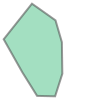

In [188]:
# Load the CSV
normalized_polygons = pd.read_csv('../data/normalized_polygons.csv')

# Convert the list of WKT strings back to shapely Polygons
normalized_polygons['polygons'] = normalized_polygons['polygons_wkt'].apply(lambda wkt_list: [shapely.wkt.loads(wkt_str) for wkt_str in eval(wkt_list)])
normalized_polygons = normalized_polygons.drop('polygons_wkt', axis=1)
display(normalized_polygons)
test_poly = normalized_polygons['polygons'][0][0]
display(test_poly)

In [221]:
input_laz_dir = '../data/normalized_lazFiles/'
output_laz_dir = '../data/downsampled_class_lazFiles/'

In [226]:
downsample_lidar(input_laz_dir=input_laz_dir, output_laz_dir=output_laz_dir)

100%|██████████| 131/131 [05:17<00:00,  2.42s/it]


## End